### Setup

In [27]:
import pathlib
import pyaudio
import wave
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Flatten, Dense, Resizing, Normalization, Dropout, Input, MaxPooling2D
from keras.callbacks import EarlyStopping

### download dataset

In [3]:
DATASET_PATH = "data/"

file_dir = pathlib.Path(DATASET_PATH)

tf.keras.utils.get_file(
    "voicedataset.zip", 
    origin="http://aiolearn.com/dl/datasets/voicedata.zip", 
    extract=True, 
    cache_dir = ".", cache_subdir="data"
)

print("DONE")

DONE


### create dataset for model

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    file_dir, 
    batch_size=64, 
    validation_split=0.2, 
    seed=0, 
    output_sequence_length=16000, 
    subset="both"
)

print()
label_names = np.array(train_ds.class_names)
print(label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
def squeeze(audio, label):
    audio = tf.squeeze(audio ,axis=-1)
    return audio, label

train_ds = train_ds.map(squeeze , tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

### Train / Test / Validation

In [7]:
test_ds = val_ds
test_ds = test_ds.shard(num_shards=2, index=0)
val_ds = test_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_label in train_ds.take(1):
    print(example_audio.shape)
    print(example_label.shape)

(64, 16000)
(64,)


In [9]:
print(example_label)

tf.Tensor(
[0 1 4 3 0 2 7 1 5 1 2 6 0 2 2 0 0 0 1 3 7 4 6 0 0 3 6 6 1 7 7 3 5 5 6 1 4
 5 2 0 3 0 0 6 3 0 0 1 5 7 3 5 6 5 4 1 7 6 0 2 1 6 0 3], shape=(64,), dtype=int32)


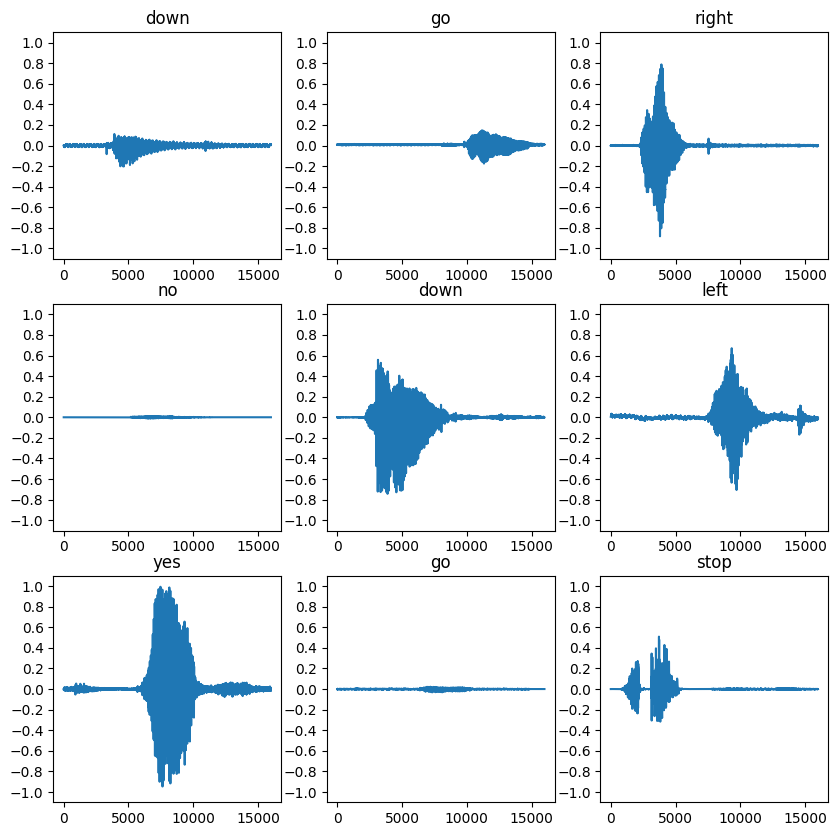

In [28]:
plt.close()
plt.figure(figsize=(10, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_label[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()

### Converting audio signals into spectrograms

In [13]:
def get_spectrogram(wavform):
    spectrogram = tf.signal.stft(
        wavform, frame_length=255, frame_step=128)
    
    magnitude_spec = tf.abs(spectrogram)
    magnitude_spec = magnitude_spec[..., tf.newaxis]

    return magnitude_spec

### Show examples of spectrograms

In [14]:
def plot_spectrogram(spectrogram, ax):
    # در اینجا بررسی می کنیم که اگر 3 بعدی بود بعد سوم (کانال ) را حدف می کنیم
    # تا فقط یک آرایه 2 بعدی (فرکانس , زمان) داشته باشیم
    if len(spectrogram) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # محاسبه مقیاس لگاریتمی انجام می ده
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    # تعریف محور های X, Y
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

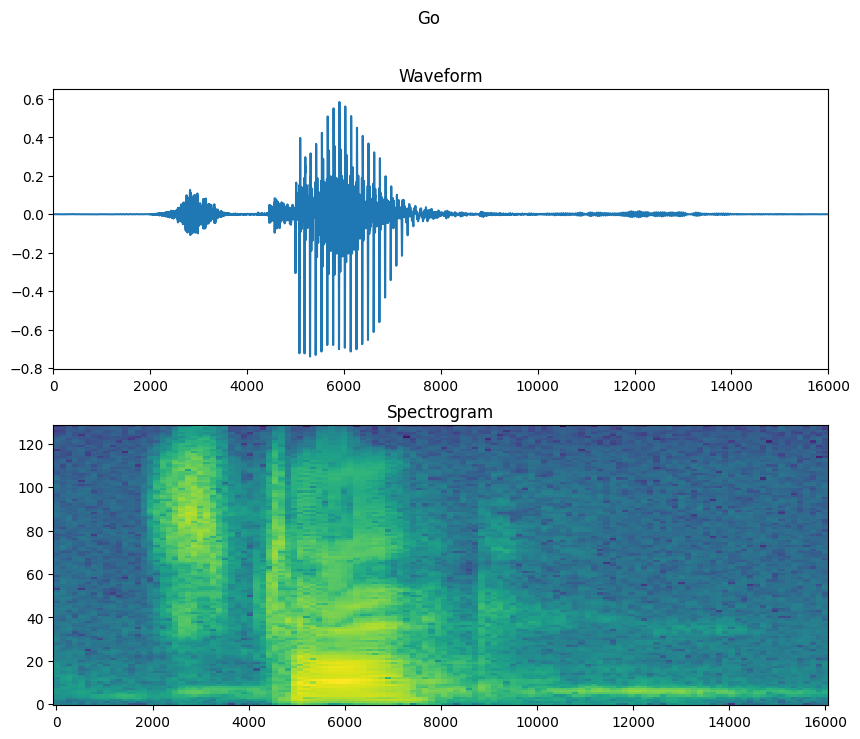

In [29]:
plt.close()
waveform = example_audio[53]
fig, axes = plt.subplots(2, figsize=(10, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(get_spectrogram(waveform), axes[1])
axes[1].set_title('Spectrogram')

plt.suptitle(label_names[example_label[9]].title())
plt.show()

### Converting dataset to Spectrogram

In [16]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spec_ds = make_spec_ds(train_ds)
test_spec_ds = make_spec_ds(test_ds)
val_spec_ds = make_spec_ds(val_ds)

### Show another samples

In [31]:
for example_spec_audio, example_spec_label in train_spec_ds.take(1): break

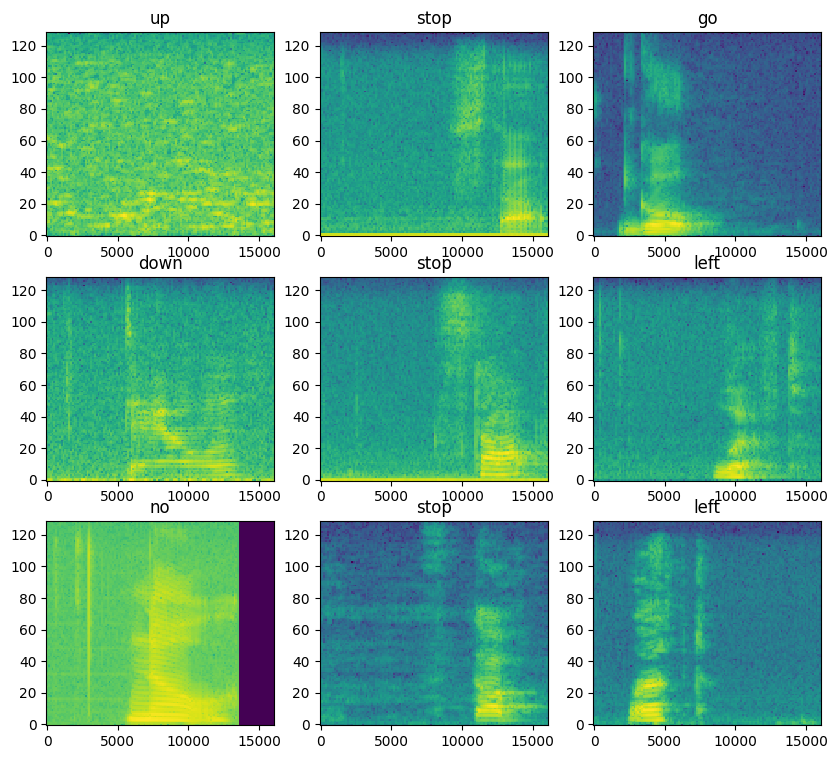

In [32]:
plt.close()
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spec_audio[i].numpy(), ax)
    ax.set_title(label_names[example_spec_label[i].numpy()])

plt.show()

In [19]:
train_spec_ds = train_spec_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_spec_ds = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spec_ds = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

### build CNN model

In [20]:
input_shape = example_spec_audio.shape[1:]
print(input_shape)
total_nums = len(label_names)

norm_layer = Normalization()
norm_layer.adapt(train_spec_ds.map(lambda spec, label: spec))

model = Sequential([
    Input(input_shape), 
    Resizing(32,32), 
    norm_layer, 
    Conv2D(32, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(), 
    Dropout(0.25), 
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5), 
    Dense(total_nums)
])

model.summary()

(124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14

### Compiling and Training model

In [ ]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=["accuracy"]
)

history = model.fit(
    train_spec_ds, 
    validation_data= val_spec_ds, 
    epochs=10, 
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
)

In [22]:
model = load_model("model.h5")

11. ارزیابی مدل با داده‌های آزمون

In [23]:
model.evaluate(test_spec_ds)

13/13 [==============================] - 0s 17ms/step - loss: 0.4809 - accuracy: 0.8353


[0.48085907101631165, 0.8353365659713745]

In [24]:
pred = model.predict(test_spec_ds)
pred = tf.argmax(pred, axis=1)

y_true = tf.reshape(list(test_spec_ds.map(lambda spec, label: label)), [-1])

13/13 [==============================] - 0s 11ms/step


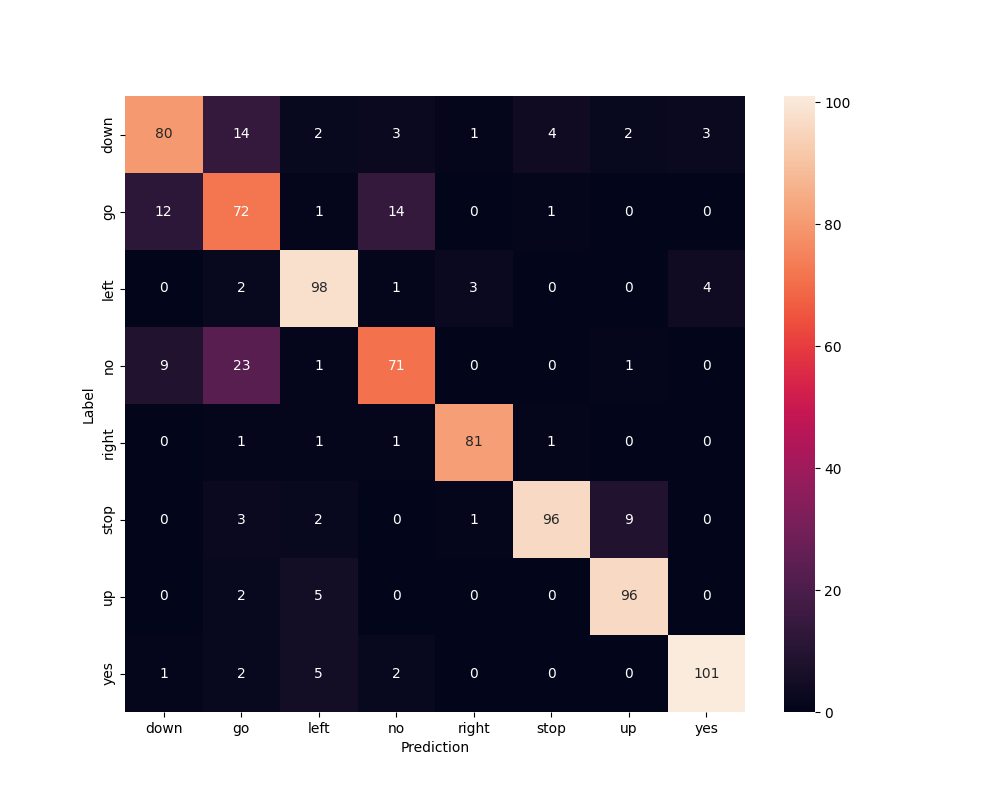

In [25]:
confusion_mtx = tf.math.confusion_matrix(y_true, pred)
plt.close()
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Testing model on new sample

Recording...
Finished recording.


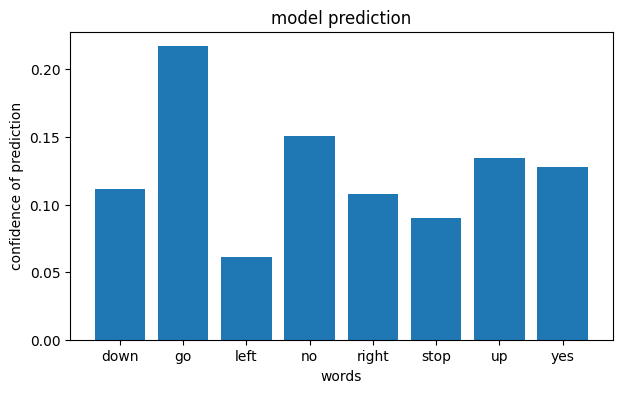

In [49]:
plt.close()
CHUNK = 1024  # Number of audio frames per buffer
FORMAT = pyaudio.paInt16  # 16-bit integers
CHANNELS = 1  # Mono audio (2 for stereo)
RATE = 16000  # Sample rate (samples per second)
RECORD_SECONDS = 1  # Duration of recording in seconds
WAVE_OUTPUT_FILENAME = "audio.wav"

p = pyaudio.PyAudio()
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,  # Set to True for input (recording)
                frames_per_buffer=CHUNK)
print("Recording...")

frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
print("Finished recording.")

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

audio = tf.io.read_file(WAVE_OUTPUT_FILENAME)
data, sample_rate = tf.audio.decode_wav(audio, desired_channels=1, desired_samples=RATE)
data = tf.squeeze(data, axis=-1)

spec = get_spectrogram(data)
spec = spec[tf.newaxis, ...]

prediction = model(spec)
plt.figure(figsize=(7, 4))
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.xlabel("words")
plt.ylabel("confidence of prediction")
plt.title("model prediction")
plt.show()